# Inference on Hodgkin-Huxley model: tutorial

In this tutorial, we use `sbi` to do inference on a [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) from neuroscience (Hodgkin and Huxley, 1952). We will learn two parameters ($\bar g_{Na}$,$\bar g_K$) based on a current-clamp recording, that we generate synthetically (in practice, this would be an experimental observation).

Note, you find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/examples/00_HH_simulator.ipynb](https://github.com/mackelab/sbi/blob/main/examples/00_HH_simulator.ipynb) in the `sbi` repository.

First we are going to import basic packages.

In [1]:
import numpy as np
import torch
from tqdm import tqdm
from joblib import Parallel, delayed

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Different required components

Before running inference, let us define the different required components:

1. observed data
1. prior over model parameters
2. simulator

## 1. Observed data

Let us assume we current-clamped a neuron and recorded the following voltage trace:


<img src="https://raw.githubusercontent.com/mackelab/delfi/master/docs/docs/tutorials/observed_voltage_trace.png" width="480">
<br>

In fact, this voltage trace was not measured experimentally but synthetically generated by simulating a Hodgkin-Huxley model with particular parameters ($\bar g_{Na}$,$\bar g_K$). We will come back to this point later in the tutorial.

## 2. Simulator

We would like to infer the posterior over the two parameters ($\bar g_{Na}$,$\bar g_K$) of a Hodgkin-Huxley model, given the observed electrophysiological recording above. The model has channel kinetics as in [Pospischil et al. 2008](https://link.springer.com/article/10.1007/s00422-008-0263-8), and is defined by the following set of differential equations (parameters of interest highlighted in orange):

$$
\scriptsize
\begin{align}
C_m\frac{dV}{dt}&=g_1\left(E_1-V\right)+
                    \color{orange}{\bar{g}_{Na}}m^3h\left(E_{Na}-V\right)+
                    \color{orange}{\bar{g}_{K}}n^4\left(E_K-V\right)+
                    \bar{g}_Mp\left(E_K-V\right)+
                    I_{inj}+
                    \sigma\eta\left(t\right)\\
\frac{dq}{dt}&=\frac{q_\infty\left(V\right)-q}{\tau_q\left(V\right)},\;q\in\{m,h,n,p\}
\end{align}
$$

Above, $V$ represents the membrane potential, $C_m$ is the membrane capacitance, $g_{\text{l}}$ is the leak conductance, $E_{\text{l}}$ is the membrane reversal potential, $\bar{g}_c$ is the density of channels of type $c$ ($\text{Na}^+$, $\text{K}^+$, M), $E_c$ is the reversal potential of $c$, ($m$, $h$, $n$, $p$) are the respective channel gating kinetic variables, and $\sigma \eta(t)$ is the intrinsic neural noise. The right hand side of the voltage dynamics is composed of a leak current, a voltage-dependent $\text{Na}^+$ current, a delayed-rectifier $\text{K}^+$ current, a slow voltage-dependent $\text{K}^+$ current responsible for spike-frequency adaptation, and an injected current $I_{\text{inj}}$. Channel gating variables $q$ have dynamics fully characterized by the neuron membrane potential $V$, given the respective steady-state $q_{\infty}(V)$ and time constant $\tau_{q}(V)$ (details in Pospischil et al. 2008).

The input current $I_{\text{inj}}$ is defined as

In [3]:
from HH_helper_functions import syn_current

I, t_on, t_off, dt, t, A_soma = syn_current()

The Hodgkin-Huxley simulator is given by:

In [4]:
from HH_helper_functions import HHsimulator

Putting the input current and the simulator together:

In [72]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:

In [6]:
# three sets of (g_Na, g_K)
params = np.array([[50., 1.],[4., 1.5],[20., 15.]])

num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

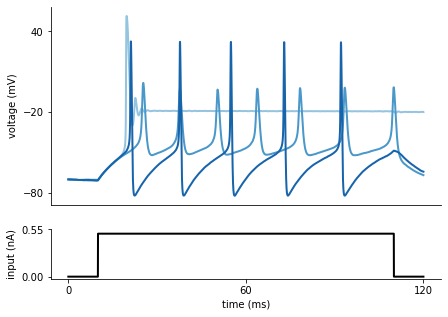

In [7]:
# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

As can be seen, the voltage traces can be quite diverse for different parameter values.

Often, we are not interested in matching the exact trace, but only in matching certain features thereof. In this example of the Hodgkin-Huxley model, the summary features are the number of spikes, the mean resting potential, the standard deviation of the resting potential, and the first four voltage moments: mean, standard deviation, skewness and kurtosis. Using the function `calculate_summary_statistics()` imported below, we obtain these statistics from the output of the Hodgkin Huxley simulator. 

In [8]:
from HH_helper_functions import calculate_summary_statistics

Lastly, we define a function that performs all of the above steps at once. The function `simulation_wrapper` takes in conductance values, runs the Hodgkin Huxley model and then returns the summary statistics.

In [9]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

`sbi` takes any function as simulator. Thus, `sbi` also has the flexibility to use simulators that utilize external packages, e.g., Brian (http://briansimulator.org/), nest (https://www.nest-simulator.org/), or NEURON (https://neuron.yale.edu/neuron/). External simulators do not even need to be Python-based as long as they store simulation outputs in a format that can be read from Python. All that is necessary is to wrap your external simulator of choice into a Python callable that takes a parameter set and outputs a set of summary statistics we want to fit the parameters to.

## 3. Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [10]:
prior_min = [.5,1e-4]
prior_max = [80.,15.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Inference
Now that we have all the required components, we can run inference with SNPE to identify parameters whose activity matches this trace.

In [11]:
posterior = infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 196 epochs.

 Note `sbi` can parallelize your simulator. If you experience problems with parallelization, try setting `num_workers=1` and please give us an error report as a [GitHub issue](https://github.com/mackelab/sbi/issues).

### Coming back to the observed data
As mentioned at the beginning of the tutorial, the observed data are generated by the Hodgkin-Huxley model with a set of known parameters ($\bar g_{Na}$,$\bar g_K$). To illustrate how to compute the summary statistics of the observed data, let us regenerate the observed data:

In [12]:
# true parameters and respective labels
true_params = np.array([50., 5.])
labels_params = [r'$g_{Na}$', r'$g_{K}$']

In [13]:
observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

As we already shown above, the observed voltage traces look as follows:

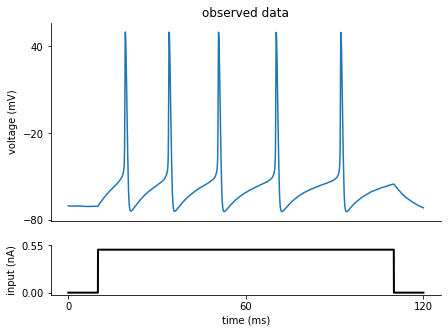

In [14]:
fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(observation_trace['time'],observation_trace['data'])
plt.ylabel('voltage (mV)')
plt.title('observed data')
plt.setp(ax, xticks=[], yticks=[-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(observation_trace['time'],I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(observation_trace['time'])/2, max(observation_trace['time'])])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

## Analysis of the posterior given the observed data

After running the inference algorithm, let us inspect the inferred posterior distribution over the parameters ($\bar g_{Na}$,$\bar g_K$), given the observed trace. To do so, we first draw samples (i.e. consistent parameter sets) from the posterior:

In [15]:
samples = posterior.sample((10000,), 
                           x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

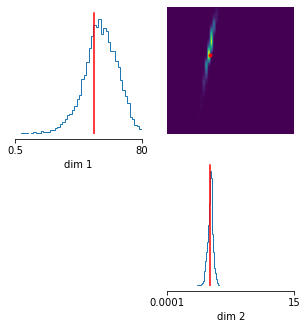

In [16]:
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

As can be seen, the inferred posterior contains the ground-truth parameters (red) in a high-probability region. Now, let us sample parameters from the posterior distribution, simulate the Hodgkin-Huxley model for this parameter set and compare the simulations with the observed data:

In [17]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), 
                                    x=observation_summary_statistics).numpy()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

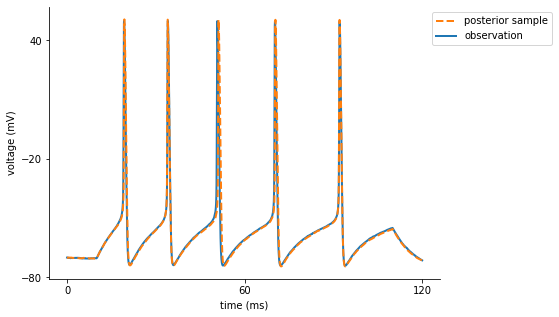

In [18]:
fig = plt.figure(figsize=(7,5))

# plot observation
t = observation_trace['time']
y_obs = observation_trace['data']
plt.plot(t, y_obs, lw=2, label='observation')

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x['data'], '--', lw=2, label='posterior sample')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

As can be seen, the sample from the inferred posterior leads to simulations that closely resemble the observed data, confirming that `SNPE` did a good job at capturing the observed data in this simple case.

## Euclidean Distance

We define the euclidean distance relative to the experimental observation

In [19]:
def simulation_wrapper_euclidean(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    data = observation_trace['data']
    obs = run_HH_model(params)['data']
    def euclidean(x,y):
        return np.linalg.norm(x-y)
    summstats = euclidean(data,obs)
    return torch.as_tensor([summstats])

In [20]:
posterior_euclidean = infer(simulation_wrapper_euclidean, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 208 epochs.

In [21]:
observation_summary_statistics = torch.tensor([0])

In [22]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior_euclidean.sample((1,), 
                                    x=observation_summary_statistics).numpy()

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

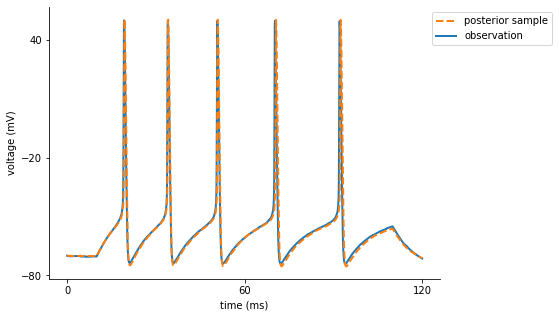

In [23]:
fig = plt.figure(figsize=(7,5))

# plot observation
t = observation_trace['time']
y_obs = observation_trace['data']
plt.plot(t, y_obs, lw=2, label='observation')

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x['data'], '--', lw=2, label='posterior sample')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

In [24]:
samples = posterior_euclidean.sample((10000,), 
                           x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

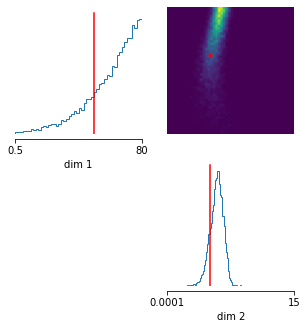

In [25]:
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

## Multiple Rounds

In [26]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

In [27]:
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)

In [29]:
inference = SNPE(prior=prior)

In [31]:
num_rounds = 5
posteriors = []
proposal = prior
x_o = observation_summary_statistics
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 104 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 92 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

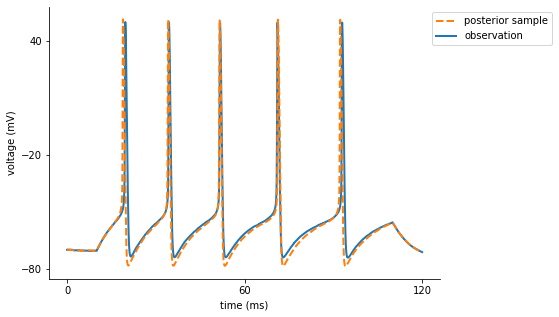

In [33]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posteriors[4].sample((1,), 
                                    x=observation_summary_statistics).numpy()

fig = plt.figure(figsize=(7,5))

# plot observation
t = observation_trace['time']
y_obs = observation_trace['data']
plt.plot(t, y_obs, lw=2, label='observation')

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x['data'], '--', lw=2, label='posterior sample')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

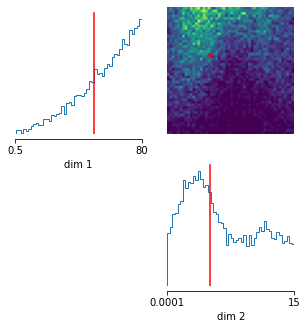

In [34]:
samples = posteriors[0].sample((10000,), 
                           x=observation_summary_statistics)

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

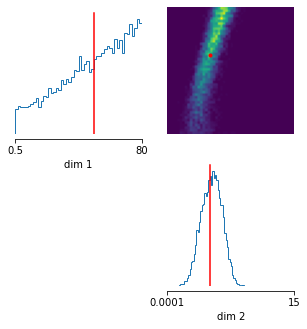

In [37]:
samples = posteriors[2].sample((10000,), 
                           x=observation_summary_statistics)

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

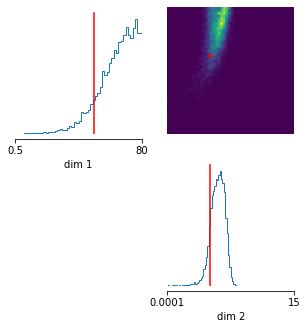

In [35]:
samples = posteriors[4].sample((10000,), 
                           x=observation_summary_statistics)

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [37]:
# true parameters and respective labels
false_params = np.array([80., 5.])
observation_trace2 = run_HH_model(false_params)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

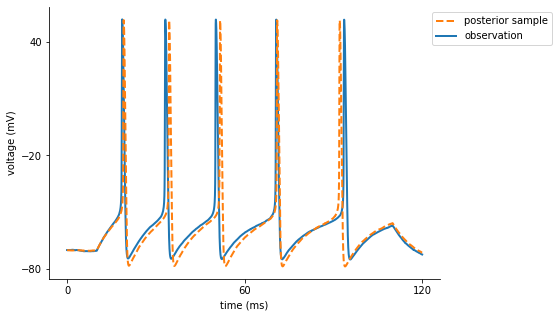

In [38]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posteriors[2].sample((1,), 
                                    x=observation_summary_statistics).numpy()

fig = plt.figure(figsize=(7,5))

# plot observation
t = observation_trace2['time']
y_obs = observation_trace2['data']
plt.plot(t, y_obs, lw=2, label='observation')

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x['data'], '--', lw=2, label='posterior sample')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

Visually, it appears that the posterior sample is a better match for the observation than the true parameters which generated it.

## Distance suitable for spikes

Euclidean distance works surprisingly well. However some sort of distance in the plane may work better, e.g. an OT distance or Hausdorff metric. There may also be a way of including multiple distance measures to improve robustness.

In [26]:
import ot
from geomloss import SamplesLoss
from scipy.spatial.distance import directed_hausdorff

sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x_pairs = torch.as_tensor(np.array([x['time'],x['data']]), dtype=torch.float32).T
    y_pairs = torch.as_tensor(np.array([y['time'],y['data']]),dtype=torch.float32).T
    print(x_pairs)
    print(y_pairs)
    return sinkhorn(x_pairs,y_pairs)

def ot_dist(x,y):
    # x = to_tensor(x)
    # y = torch.stack(y)
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    a = ot.unif(len(x_pairs))
    b = ot.unif(len(y_pairs))
    Mat = ot.dist(x_pairs, y_pairs, metric='euclidean')
    #Mat1 /= Mat1.max()
    distance = torch.as_tensor(ot.emd2(a,b,Mat))
    return distance

def hausdorff_dist(x,y):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])



[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [27]:
def simulation_wrapper_sinkhorn(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    data = observation_trace
    obs = run_HH_model(params)
    summstats = sinkhorn_t(data,obs)
    return torch.as_tensor([summstats])
    
def simulation_wrapper_ot(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    data = observation_trace
    obs = run_HH_model(params)
    summstats = ot_dist(data,obs)
    return torch.as_tensor([summstats])

def simulation_wrapper_hausdorff(params):
    data = observation_trace
    obs = run_HH_model(params)
    summstats = hausdorff_dist(data,obs)
    return torch.as_tensor([summstats[0]])

In [28]:
posterior_hausdorff = infer(simulation_wrapper_hausdorff, prior, method='SNPE', 
                  num_simulations=300, num_workers=7)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 158 epochs.

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining -11 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


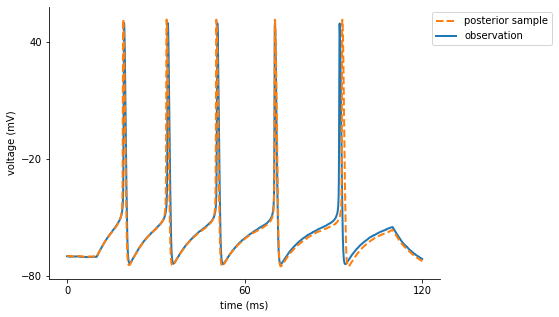

In [29]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior_hausdorff.sample((1,), 
                                    x=observation_summary_statistics).numpy()
fig = plt.figure(figsize=(7,5))

# plot observation
t = observation_trace['time']
y_obs = observation_trace['data']
plt.plot(t, y_obs, lw=2, label='observation')

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x['data'], '--', lw=2, label='posterior sample')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9979 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


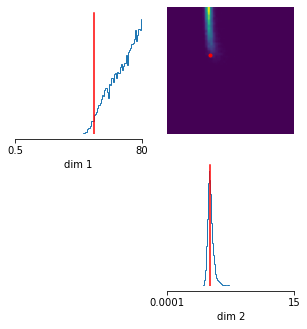

In [30]:
samples = posterior_hausdorff.sample((10000,), 
                           x=observation_summary_statistics)
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [32]:
posterior_sinkhorn = infer(simulation_wrapper_ot, prior, method='APT', 
                  num_simulations=300, num_workers=4)

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/sragy/anaconda3/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

In [47]:
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff, prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 205 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 130 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

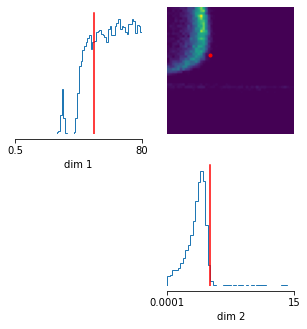

In [48]:
samples = posteriors[4].sample((10000,), 
                           x=observation_summary_statistics)

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

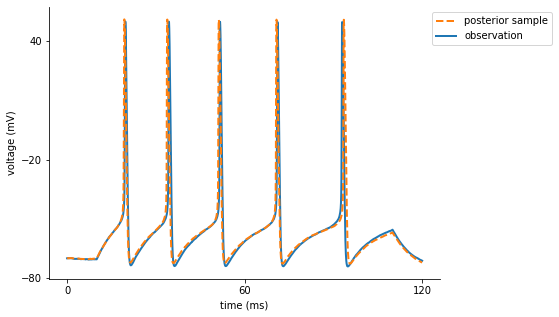

In [51]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posteriors[4].sample((1,), 
                                    x=observation_summary_statistics).numpy()

fig = plt.figure(figsize=(7,5))

# plot observation
t = observation_trace['time']
y_obs = observation_trace['data']
plt.plot(t, y_obs, lw=2, label='observation')

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x['data'], '--', lw=2, label='posterior sample')

plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

## Small disks

In [79]:
def simulation_wrapper_hausdorff_disk(radius):
    
    def simulation_wrapper_interior(params):
        data = observation_trace
        obs = run_HH_model(params)
        summstats = hausdorff_dist(data,obs)[0]
        max_dist = max(summstats, radius)
        return torch.as_tensor([max_dist])

    return simulation_wrapper_interior

def simulation_wrapper_euclidean_disk(radius):
    
    def simulation_wrapper_interior(params):
        data = observation_trace
        obs = run_HH_model(params)
        def euclidean(x,y):
            return np.linalg.norm(x-y)
        summstats = euclidean(data,obs)
        max_dist = max(summstats, radius)
        return torch.as_tensor([max_dist])

    return simulation_wrapper_interior

In [36]:
posterior_hausdorff = infer(simulation_wrapper_hausdorff_disk(2), prior, method='SNPE', 
                  num_simulations=300, num_workers=7)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 297 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

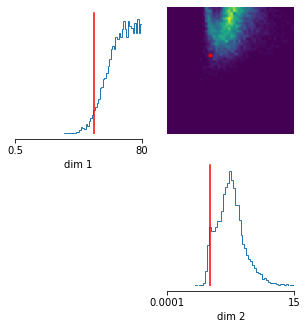

In [38]:
samples = posterior_hausdorff.sample((10000,), 
                           x=torch.tensor([2]))

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 96 epochs.ural network. Epochs trained: 33

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

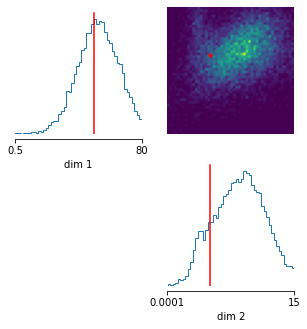

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

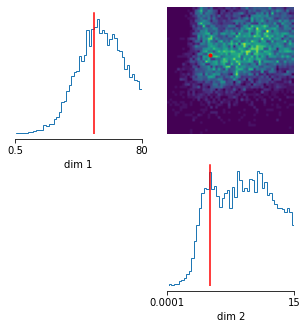

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

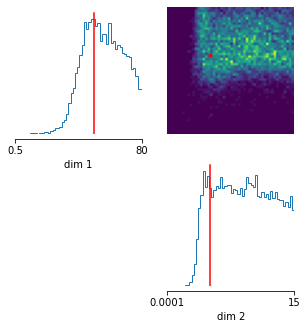

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

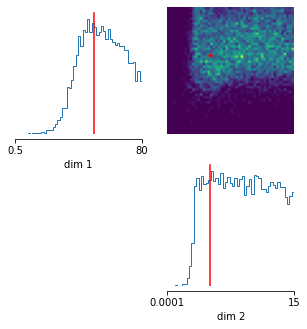

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

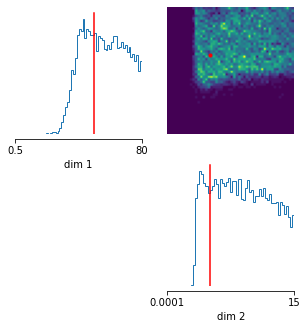

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

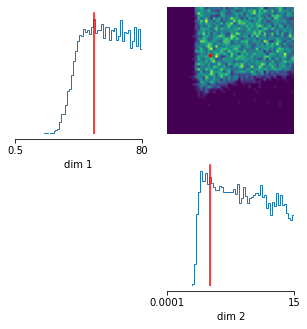

In [49]:
num_rounds = 6
posteriors = []
#x_o = torch.linspace(5,0,6)
x_o = torch.tensor([5])
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o[0]), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    6.6s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    8.9s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.5s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   16.1s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   24.4s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   29.2s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   33.0s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:   39.0s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   44.1s
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:   50.2s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   55.9s
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.2min
[Parallel(

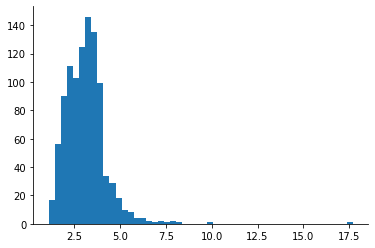

In [50]:
samples = posterior.sample((1000,))
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in samples)
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

In [ ]:
samples = posterior.sample((1000,))
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in samples)
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

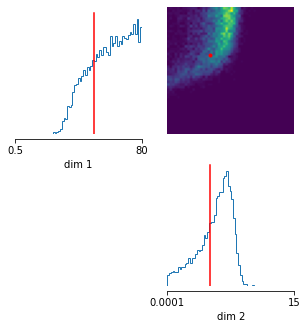

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

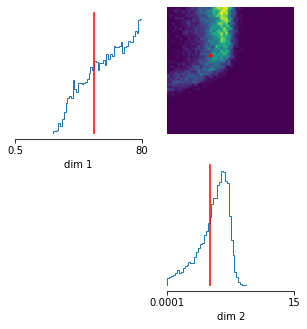

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

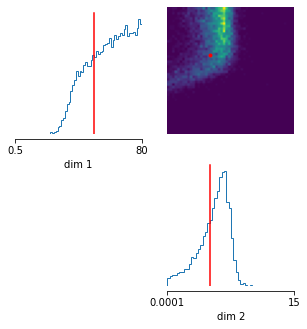

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 124 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

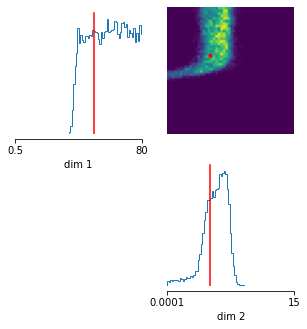

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

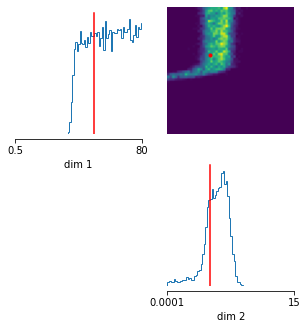

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

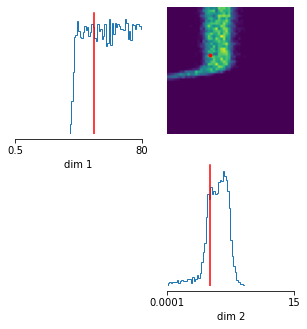

In [51]:
num_rounds = 6
posteriors = []
#x_o = torch.linspace(5,0,6)
x_o = torch.tensor([2])
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o[0]), prior)
proposal = posterior.set_default_x(torch.tensor([5]))
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    7.0s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   11.6s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   16.3s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   24.3s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   33.5s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   41.2s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   51.0s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   59.7s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.2min
[Parallel(

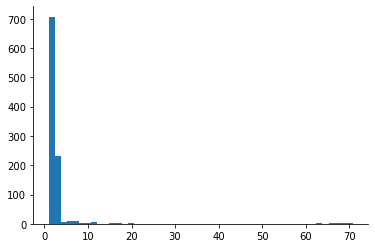

In [52]:
samples = posterior.sample((1000,))
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in samples)
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

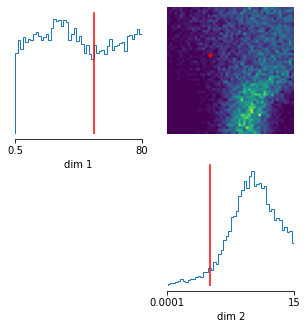

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

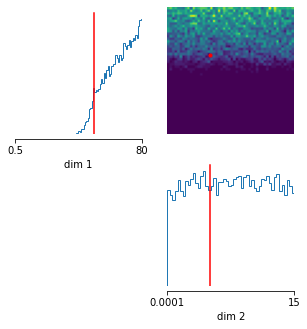

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

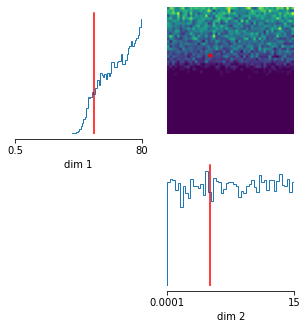

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 74 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9993 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


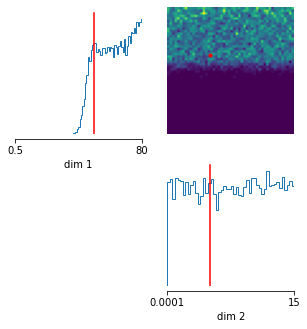

In [53]:
num_rounds = 4
posteriors = []
#x_o = torch.linspace(5,0,6)
x_o = torch.tensor([0])
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o[0]), prior)
proposal = posterior.set_default_x(torch.tensor([2]))
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 185 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    4.6s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    8.9s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   13.5s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   18.8s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   26.4s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   32.1s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   40.2s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   45.8s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   51.8s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 131 task

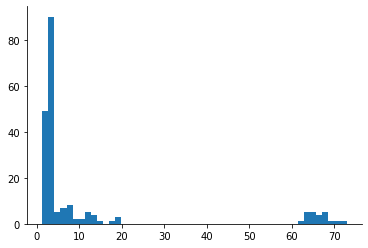

In [55]:
samples = posterior.sample((200,))
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in samples)
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    8.0s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   13.0s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   18.7s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   27.9s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   34.6s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   43.9s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   53.1s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.7min
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.2min
[Parallel(

(array([12., 28., 42., 42., 21., 20., 14., 12.,  3.,  6.]),
 array([0.8721543, 1.0933148, 1.3144753, 1.5356357, 1.7567962, 1.9779567,
        2.1991172, 2.4202776, 2.641438 , 2.8625987, 3.083759 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

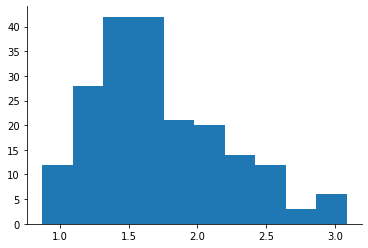

In [56]:
typical_distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(true_params) for _ in range(200))
plt.hist(torch.cat(typical_distances).numpy())

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 200 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

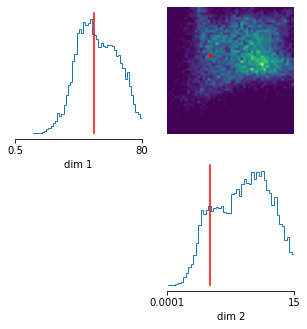

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

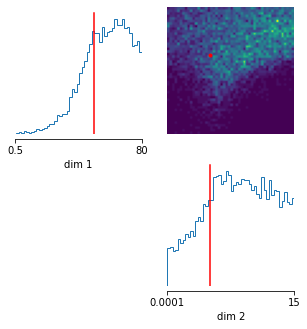

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 86 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

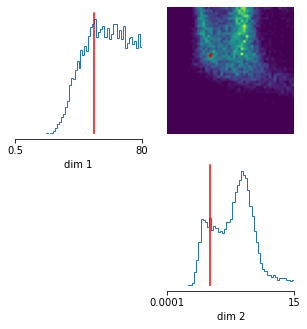

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 96 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

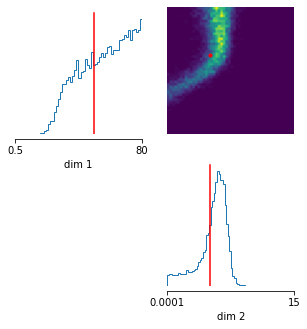

In [57]:
num_rounds = 4
posteriors = []
x_o = torch.linspace(5,1.5,4)
for i in range(num_rounds):
    simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o[i]), prior)
    if i == 0:
        proposal = prior
    else:
        proposal = posterior
    inference = SNPE(prior=prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=300, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x([x_o[i]])
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [58]:
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff, prior)
proposal = posterior
inference = SNPE(prior=prior)
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=300, num_workers=7)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 96 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

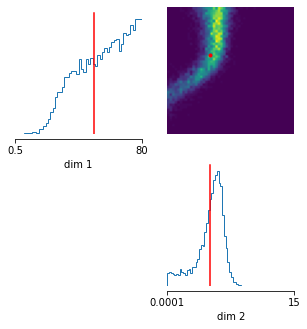

In [63]:
samples = posteriors[-2].sample((10000,),x=torch.tensor([1]))
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

## Summary comparisons (their summaries on our results)
The summary features, in order, are the number of spikes, the mean resting potential, the standard deviation of the resting potential, and the first four voltage moments: mean, standard deviation, skewness and kurtosis

In [66]:
# def plot_summaries(posterior, x):
#     samples = posterior.sample((100,),x=x)
#     #all_summs = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(samples)])
#     all_summs=Parallel(n_jobs=7, verbose=10)(simulation_wrapper(sample) for sample in samples)
#     all_summs=np.array([summaries.numpy() for summaries in all_summs])
#     for i in range(7):
#         plt.hist(all_summs[:,i],bins=50)
#         plt.figure()

def plot_summaries(posterior, euclidean_post, hausdorff_post, x):
    samples = posterior.sample((120,),x=x)
    samples_euc = euclidean_post.sample((120,),x=torch.tensor([0]))
    samples_haus = hausdorff_post.sample((120,),x=torch.tensor([0]))
    all_summs = np.array([simulation_wrapper(sample).numpy() for sample in samples])
    all_summs_e = np.array([simulation_wrapper(sample).numpy() for sample in samples_euc])
    all_summs_h = np.array([simulation_wrapper(sample).numpy() for sample in samples_haus])
    # all_summs=Parallel(n_jobs=7, verbose=10)(simulation_wrapper(sample) for sample in samples)
    # all_summs=np.array([summaries.numpy() for summaries in all_sums])
    for i in range(7):
        plt.hist(all_summs[:,i],alpha=0.75)
        plt.hist(all_summs_e[:,i],alpha=0.75)
        plt.hist(all_summs_h[:,i],alpha=0.75)
        plt.figure()

In [45]:
observation_summary_statistics = calculate_summary_statistics(observation_trace)
distance_summ_stat = torch.tensor([0])

Drawing 120 posterior samples:   0%|          | 0/120 [00:00<?, ?it/s]

Drawing 120 posterior samples:   0%|          | 0/120 [00:00<?, ?it/s]

Drawing 120 posterior samples:   0%|          | 0/120 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 104 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


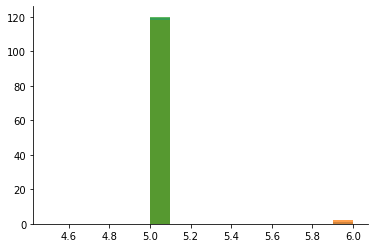

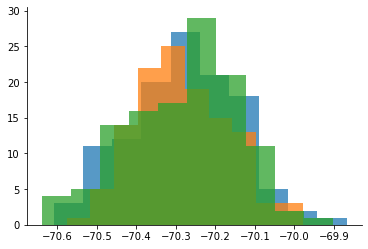

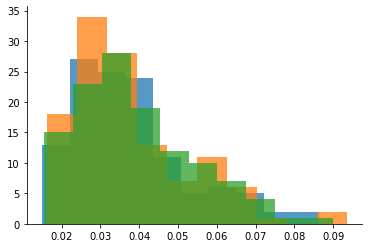

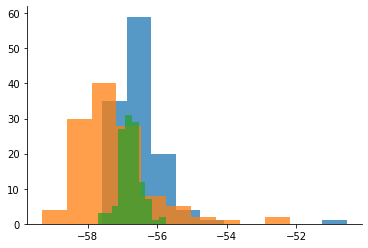

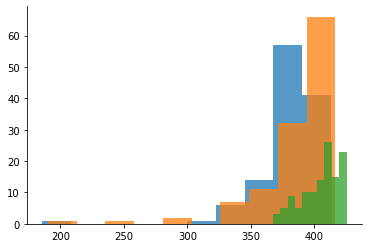

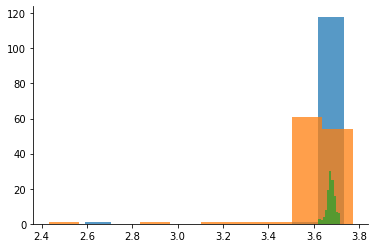

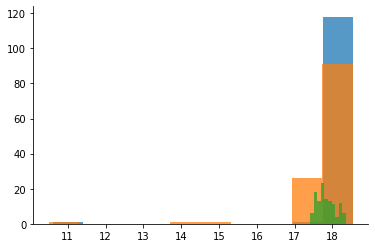

<Figure size 432x288 with 0 Axes>

In [67]:
plot_summaries(posterior,posterior_euclidean, posterior_hausdorff, observation_summary_statistics)

In [69]:
observation_summary_statistics

array([ 5.00000000e+00, -7.02794188e+01,  3.44545294e-02, -5.64523148e+01,
        3.75389288e+02,  3.70043923e+00,  1.83040721e+01])

In [77]:
def plot_summaries(posterior, euclidean_post, hausdorff_post, x):
    samples = posterior.sample((1000,),x=x)
    samples_euc = euclidean_post.sample((1000,),x=torch.tensor([0]))
    samples_haus = hausdorff_post.sample((1000,),x=torch.tensor([0]))
    all_summs = np.array([simulation_wrapper(sample).numpy() for sample in samples])
    all_summs_e = np.array([simulation_wrapper(sample).numpy() for sample in samples_euc])
    all_summs_h = np.array([simulation_wrapper(sample).numpy() for sample in samples_haus])
    # all_summs=Parallel(n_jobs=7, verbose=10)(simulation_wrapper(sample) for sample in samples)
    # all_summs=np.array([summaries.numpy() for summaries in all_sums])
    for i in range(7):
        all_summs_combined = np.concatenate([all_summs, all_summs_e, all_summs_h])
        bins_min = min(all_summs_combined[:,i])
        bins_max = max(all_summs_combined[:,i])
        bins = np.linspace(bins_min,bins_max,50)
        plt.hist(all_summs[:,i],bins=bins,alpha=0.5)
        plt.hist(all_summs_e[:,i],bins=bins,alpha=0.5)
        plt.hist(all_summs_h[:,i],bins=bins,alpha=0.5)
        plt.axvline(x[i])
        plt.figure()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 985 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


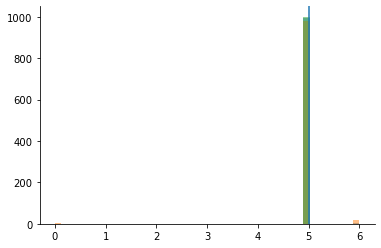

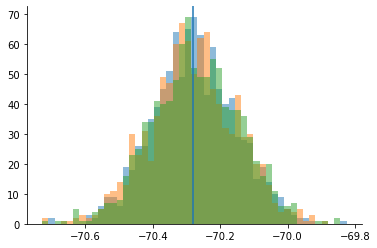

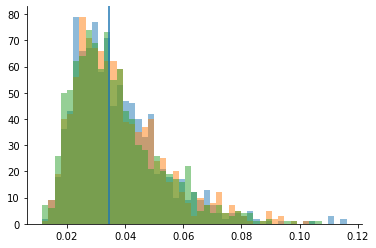

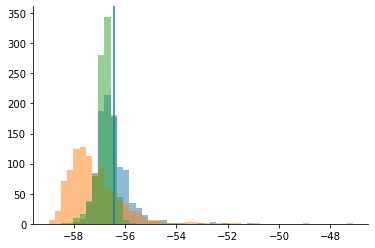

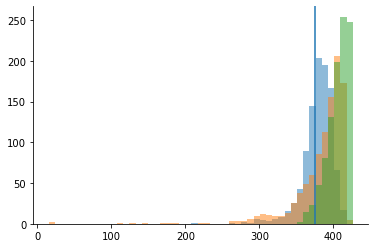

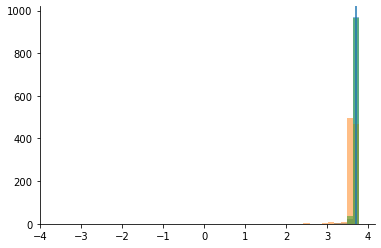

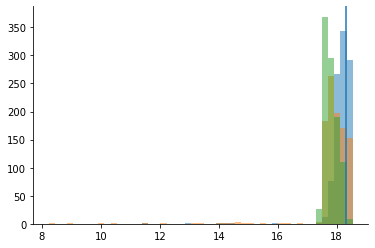

<Figure size 432x288 with 0 Axes>

In [78]:
plot_summaries(posterior,posterior_euclidean, posterior_hausdorff, observation_summary_statistics)

## Summary comparisons (our summaries on their results)

Consider how their summaries look on our posterior and vice versa.

In [62]:
our_posterior = posteriors[4]
samples = our_posterior.sample((1000,1))
distances = Parallel(n_jobs=7, verbose=5)(
    delayed(simulation_wrapper_hausdorff)(params) for params in tqdm(samples))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    3.8s








[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   29.3s












[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.3min


















[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:  2.3min
























[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  3.8min




























[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed:  5.6min

































[Parallel(n_jobs=7)]: Done 868 tasks      | elapsed:  7.5min

















100%|██████████| 1000/1000 [08:21<00:00,  1.99it/s]
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:  8.5min finished


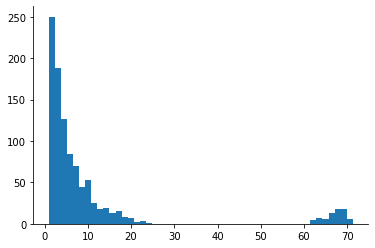

In [69]:
plt.hist(torch.cat(distances).numpy(), bins=50)
plt.show()

In [72]:
their_posterior = infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 160 epochs.

In [75]:
observation_summary_statistics = calculate_summary_statistics(observation_trace)
samples = their_posterior.sample((1000,1),x=observation_summary_statistics)
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in tqdm(samples))
distances = torch.cat(distances).numpy()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:59<00:00,  2.09it/s]
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:  8.1min finished


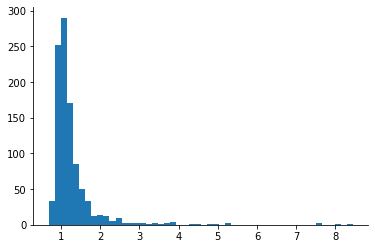

In [77]:
plt.hist(np.array(distances),bins=50)
plt.show()

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    7.7s
 25%|██▌       | 252/1000 [01:58<04:03,  3.07it/s][Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   15.6s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   21.1s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   25.3s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   30.9s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   36.3s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   41.7s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:   50.9s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   59.5s
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]:

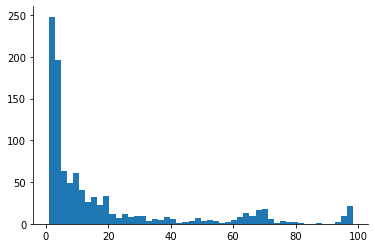

In [124]:
samples = prior.sample((1000,))
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in samples)
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

## Culling large distances (attempt)

In [133]:
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff, prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    indices = x.topk(40,axis=0,largest=False).indices.reshape(40)
    density_estimator = inference.append_simulations(theta[indices], x[indices], proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 69 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 5

 Training neural network. Epochs trained: 11

 Training neural network. Epochs trained: 14

 Training neural network. Epochs trained: 18

 Neural network successfully converged after 21 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 88 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

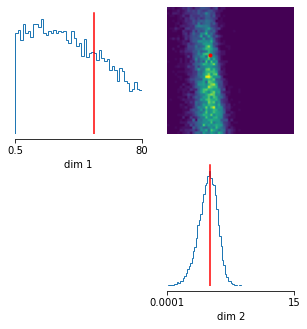

In [134]:
samples = posteriors[4].sample((10000,), 
                           x=torch.tensor([0]))

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    4.9s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    7.3s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.6s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   18.6s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   22.5s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   28.6s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   36.0s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   40.8s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:   48.6s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   56.1s
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.5min
[Parallel(

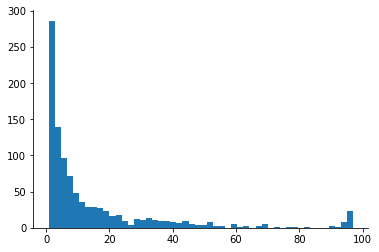

In [135]:
distances = Parallel(n_jobs=7, verbose = 10)(
    delayed(simulation_wrapper_hausdorff)(params) for params in samples[0:1000])
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

In [147]:
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)
inference = SNPE(prior=prior)
num_rounds = 5
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    indices = x.topk(40,axis=0,largest=False).indices.reshape(40)
    density_estimator = inference.append_simulations(theta[indices], x[indices], proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 53 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 2

 Training neural network. Epochs trained: 6

 Training neural network. Epochs trained: 10

 Training neural network. Epochs trained: 14

 Training neural network. Epochs trained: 18

 Training neural network. Epochs trained: 20

 Training neural network. Epochs trained: 24

 Training neural network. Epochs trained: 28

 Training neural network. Epochs trained: 32

 Training neural network. Epochs trained: 37

 Training neural network. Epochs trained: 41

 Training neural network. Epochs trained: 46

 Training neural network. Epochs trained: 51

 Neural network successfully converged after 54 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

  3%|▎         | 27/1000 [1:03:04<37:52:45, 140.15s/it]


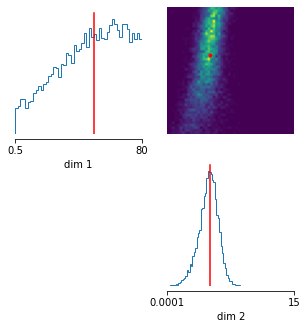

In [148]:
samples = posteriors[-1].sample((10000,), 
                           x=torch.tensor([0]))

fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    4.7s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    7.3s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    9.9s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   14.4s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   17.4s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   22.5s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   27.6s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   31.1s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:   39.0s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   44.7s
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:   52.4s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   59.7s
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.3min
[Parallel(

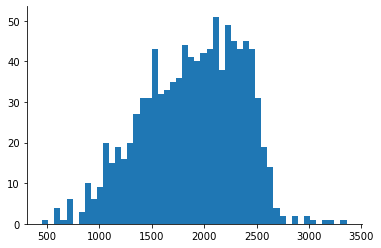

In [149]:
distances = Parallel(n_jobs=7, verbose = 10)(
    delayed(simulation_wrapper_euclidean)(params) for params in samples[0:1000])
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

In [150]:
observation_summary_statistics = calculate_summary_statistics(observation_trace)
samples = their_posterior.sample((1000,1),x=observation_summary_statistics)
distances = Parallel(n_jobs=7, verbose=10)(
    delayed(simulation_wrapper_euclidean)(params) for params in samples)
distances = torch.cat(distances).numpy()
plt.hist(distances,bins=50)
plt.show()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    4.8s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    7.4s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   10.0s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   14.7s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   17.6s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   22.3s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   27.9s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   32.2s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:   38.6s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   43.8s
[Parallel(n_jobs=7)]: Done 131 tasks      | elapsed:   51.0s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   57.4s
[Parallel(n_jobs=7)]: Done 167 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  1.2min
[Parallel(

In [ ]:
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)
inference = SNPE(prior=prior)
num_rounds = 10
posteriors = []
proposal = prior
x_o = torch.tensor([0])
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    indices = x.topk(40,axis=0,largest=False).indices.reshape(40)
    density_estimator = inference.append_simulations(theta[indices], x[indices], proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

In [137]:
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

In [141]:
indices = x.topk(40,axis=0,largest=False).indices.reshape(40)

## References


A. L. Hodgkin and A. F. Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology, 117(4):500–544, 1952.

M. Pospischil, M. Toledo-Rodriguez, C. Monier, Z. Piwkowska, T. Bal, Y. Frégnac, H. Markram, and A. Destexhe. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biological Cybernetics, 99(4-5), 2008.

## Rough calculations

In [43]:
extra = torch.as_tensor(np.array([run_HH_model((50,5))['time'],run_HH_model((50,5))['data']])).T

In [46]:
obs_leaves = torch.as_tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
                           [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
                           [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
                           [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
                           [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
                           [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
                           [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
                           [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
                           [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
                           [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
                           [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
                           [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
                           [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
                           [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
                           [12.21401828,  6.76059035,  6.94920042,  7.42823701],
                           [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
                           [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
                           [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
                           [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
                           [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
                           [15.40023764,  9.10884407,  8.93836964,  8.61970667],
                           [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
                           [19.81054106, 11.90268453, 11.60989346, 10.76953856],
                           [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
                           [25.74331932, 15.63430056, 14.83860792, 14.07189108],
                           [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
                           [12.34604239,  7.78770185,  6.76075998,  6.78498685],
                           [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
                           [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
                           [16.28983576,  9.66683929,  9.24891886,  9.28970032],
                           [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
                           [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
                           [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
                           [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
                           [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]])

obs_leaves2=torch.as_tensor([[ 25.8005,  15.8486,  13.7905,  14.9743],
        [ 64.6767,  39.8886,  34.8096,  37.1519],
        [112.1183,  68.9756,  59.4660,  65.3958],
        [ 17.2854,   9.8922,   9.2324,  10.7553],
        [  8.0760,   4.8046,   4.1940,   4.9540],
        [ 32.6218,  17.6533,  21.0402,  17.6020],
        [ 78.1670,  42.4337,  50.0361,  42.4953],
        [ 23.3093,  12.4575,  14.6925,  13.1246],
        [  8.5133,   4.5174,   5.0757,   5.1276],
        [ 17.5119,   8.7775,  10.6228,  10.8064],
        [ 11.6579,   5.0303,   7.2342,   7.6330],
        [  0.8138,   0.3167,   0.5029,   0.5491],
        [  0.5715,   0.3441,   0.2433,   0.3707]])

In [48]:
sinkhorn(obs_leaves,obs_leaves2)

tensor(22.9926)

In [51]:
extra.size()

torch.Size([12001, 2])

In [52]:
obs_leaves.size()

torch.Size([35, 4])

In [31]:
observation_summary_statistics

tensor([0])

In [34]:
max(hausdorff_dist(observation_trace, observation_trace)[0],-1)

0.0